# Homework Week 06-07
Nicola Zomer <br>
27 November, 2022

## Assignment
Consider a consumer resource model where the supply rate is $s(c) = \omega c (1 – c/K)$ and the resource concentration $r(c) = c$ is linear, for $S=5$ species and $R=5$ resources. Assign the metabolic strategies at random from a Uniform Distribution between $[0, 0.2]$, while set all other parameters to 1 and choose the death rate small enough as you prefer.
1. Perform the simulations of the full CRM model and compare the stationary solution you find numerically with those obtained analytically.
2. Set $w=10$ and do the simulation of the quasi stationary approximation (finding first $c^*$ and then simulating $n(t,c^*)$) and compare it with the simulations of the full CRM (keeping fix the metabolic strategies in the two cases for a given realization). Do several (e.g. >20) realizations of the dynamics to obtain a statistics of the species population stationary states in the two cases, represent each population through a Box-Whisker Plot both for the full CRM and the GLV and compare the two.
3. Does the quasi-stationary approximation works if $w=0.1$? Why?

# Introduction
It is possible to generalize the MacArthur’s Consumer Resource Model to $m$ species and $p$ resources:
$$
\begin{align}
    \dot{n}_\sigma &= n_\sigma\left(\sum_{i=1}^p v_i \alpha_{\sigma i} r_i(c_i)-\delta_\sigma \right) & &\quad \sigma=1, ..., m\\
    \dot{c}_i &= s_i - \sum_{\sigma=1}^m n_\sigma \alpha_{\sigma i} r_i(c_i)  & &\quad i=1, ..., p\\
\end{align}
$$
where: 
- $\alpha_{\sigma i}$ is the _metabolic strategy_ and represents the metabolic energy that species $\sigma$ allocates to consume resource $i$;
- $s_i$ is the supply rate, so the growth rate of the $i-th$ resource;
- $v_i$ is the resource values, i.e. it describes the efficiency of the conversion of the resources into growth of a given species;
- $r_i$ is the resource uptaken rate;
- $\delta_\sigma$ is the death rate.

Notice that only if $\alpha_{\sigma i}>0$ species $\sigma$ can eat resource $i$. 

In this homework we consider $m=5$ species and $p=5$ resources, a supply rate $s(c) = w c (1 – c/K)$ and a linear resource supply rate $r(c) = c$. Moreover, we set $v_i=w=K=1$. 

# Point 1

In this case where $m=p$ the stationary solution can be obtained analytically without needing to assume $\delta_\sigma$ constant or introducing a total energy budget. If we consider the stationary state in which $n_\sigma\neq 0 \; \forall \sigma=1, ..., m$ then the stationary state corresponds to the solution of the following system of equations:
$$
\begin{equation}
    \begin{cases}
    \dot{n}_\sigma &= 0 \\
    \dot{c}_i &= 0  
    \end{cases} \qquad \Rightarrow \qquad \begin{cases}
    0 &= \sum_{i=1}^p v_i \alpha_{\sigma i} r_i(c_i)-\delta_\sigma & &\quad \sigma=1, ..., m\\
    0 &= s_i - \sum_{\sigma=1}^m n_\sigma \alpha_{\sigma i} r_i(c_i)  & &\quad i=1, ..., p\\
    \end{cases}
\end{equation}
$$

We can exploit the fact that $v_i=1$, $r(c_i)=c_i$ and $s_i = \omega c_i (1 – c_i/K)$ to rewrite the system as:
$$
\begin{equation}
    \begin{cases}
    \sum_{i=1}^p \alpha_{\sigma i} c_i &=  \delta_\sigma & &\quad \sigma=1, ..., m\\
    \omega (1 – c_i/K) &= \sum_{\sigma=1}^m n_\sigma \alpha_{\sigma i}   & &\quad i=1, ..., p\\
    \end{cases}
\end{equation}
$$

where in the second equation we used the fact that the $c_i$ can be extracted from the summation at the right hand side. Notice that the first set of equations are $m$ equations in $p$ variables. Since in this case $m=p=5$, this system of equations admits a unique solution.

We can write them in vectorial form, calling $A$ the matrix describing the metabolic strategies $\alpha_{\sigma i}$:
$$
\begin{equation}
    \begin{cases}
    A \vec{c}^* &=  \vec{\delta}\\
    \omega (\vec{1} – \vec{c}^*/K) &= \alpha^T \vec{n}^*\\
    \end{cases}
\end{equation}
$$

From which we can derive the stationary solutions:
$$
\begin{align}
    \vec{c}^* &=  A^{-1}\vec{\delta} \\
    \vec{n}^* &=  (A^T)^{-1}\omega (\vec{1} – \vec{c}^*/K)
\end{align}
$$


## Simulation parameters 
Initial conditions for $n_\sigma$ and $c_i$ are drawn from a half normal distribution. The death rates $\delta_\sigma$ for now are sampled from a normal distribution with parameters `loc=0.0`, `scale=0.5`.


In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp

np.random.seed(2222)

# metabolic stategies
def metabolic_strategies(m, p): 
    sigma_ = np.random.uniform(0, 0.2, (m, p))
    
    return sigma_

# resource uptake rate
def resource_uptake(c):
    return c

# supply rate
def supply(c, omega_, k_):
    return omega_*c*(1-c/k_)

# function computing the derivative
def derivative(y, time, alpha, dr, omega_, k_, n_species, n_resources):
    '''
    y = (n_vec, c_vec) -> as a list
    
    time  -> time instant
    alpha -> metabolic strategies
    dr    -> death rate vector
    
    '''
    assert len(y)==n_species+n_resources, 'wrong dimensions'
    
    n_vec = np.array(y[0:n_species]) 
    c_vec = np.array(y[n_species:]) 
    
    n_dot = n_vec*(np.dot(alpha, resource_uptake(c_vec))-dr) 
    c_dot = supply(c_vec, omega_, k_)-np.dot(alpha.T, n_vec)*resource_uptake(c_vec) 
    
    return n_dot.tolist()+ c_dot.tolist()

# parameters of the model
m=5
p=5
omega = 1
kappa = 1
delta = np.abs(np.random.normal(0, 0.5, size = m))

print('Death rates:', delta.round(4))

# initialization
m0 = list(np.abs(np.random.normal(5, 1, size = m)))
p0 = list(np.abs(np.random.normal(0.5, 0.5, size = p)))

# build alpha 
met_strat = metabolic_strategies(m, p)

# numerical solution
time_vec = np.linspace(0, 200, 200)
y = odeint(derivative, y0=m0+p0, t=time_vec, args=(met_strat, delta, omega, kappa, m, p))
# y = solve_ivp(fun=derivative, y0=m0+p0, t_span=(0, 200), args=(met_strat, delta, omega, kappa, m, p))



Death rates: [0.4704 0.5065 0.2323 0.3576 0.2749]


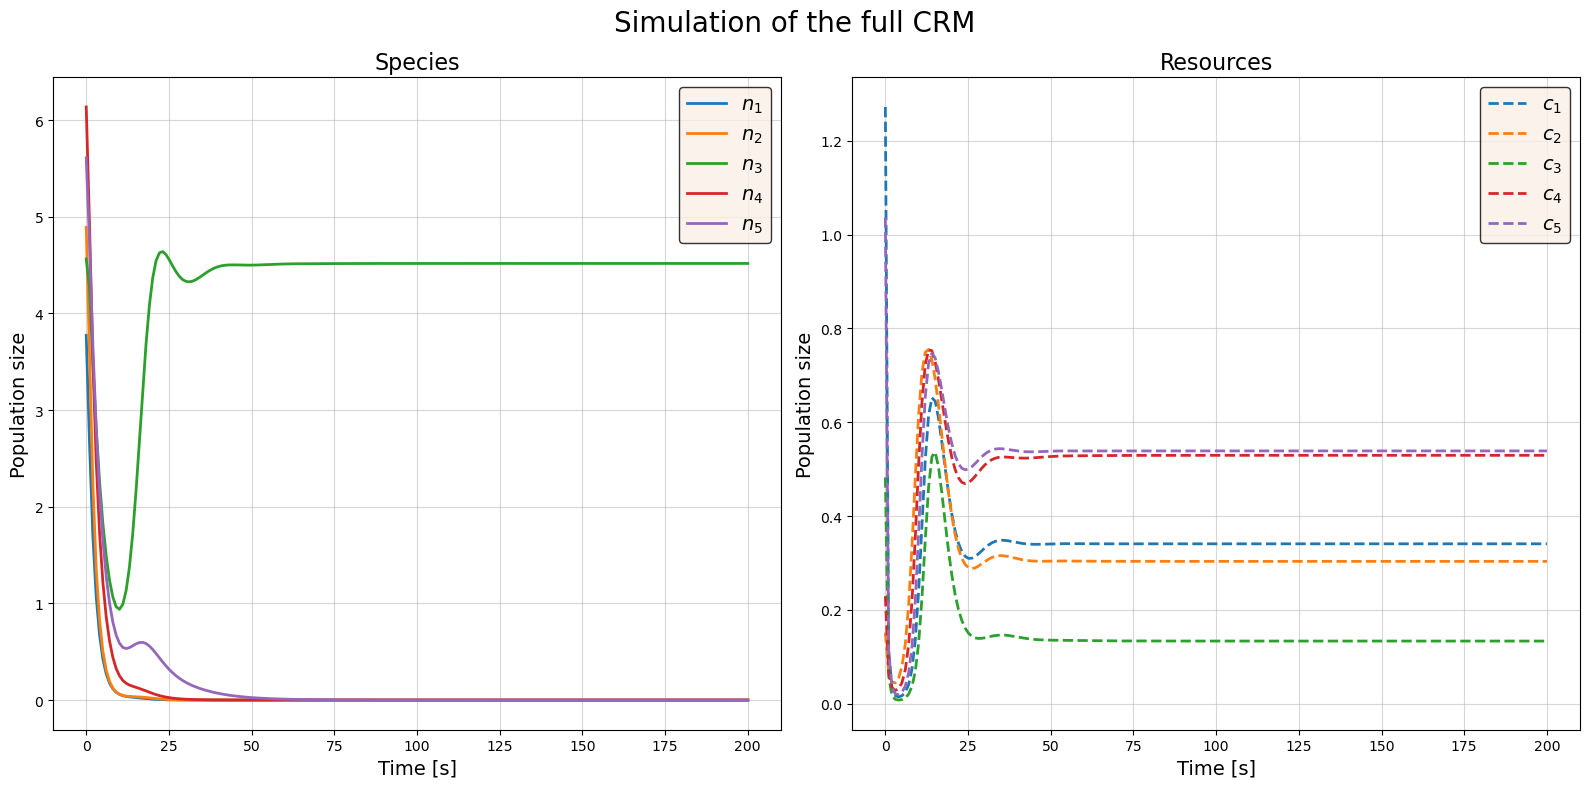

In [215]:
# plot the results
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Simulation of the full CRM', fontsize=20)

species = ax0.plot(time_vec, y[:, 0:m], linewidth=2)
ax0.set_xlabel('Time [s]', fontsize=14)
ax0.set_ylabel('Population size', fontsize=14)
ax0.grid(alpha=0.5)
ax0.legend(species, ['$n_'+str(i+1)+'$' for i in range(m)], edgecolor='black', facecolor='linen', fontsize=14 , loc ='best')
ax0.set_title('Species', fontsize=16)

resources = ax1.plot(time_vec, y[:, m:], linewidth=2, linestyle = 'dashed')
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel('Population size', fontsize=14)
ax1.grid(alpha=0.5)
ax1.legend(resources, ['$c_'+str(i+1)+'$' for i in range(m)], edgecolor='black', facecolor='linen', fontsize=14 , loc ='best')
ax1.set_title('Resources', fontsize=16)

plt.tight_layout()
plt.show()

In [216]:
# analytical solutions

def resources_stationary_anal_0(alpha, dr, notnegative=False):
    c_anal = np.linalg.inv(alpha).dot(dr)
    
    if notnegative:
        c_anal[c_anal<0]=0
    
    return c_anal

def species_stationary_anal_0(alpha, omega_, k_, c_anal=None, dr=None, notnegative=False):
    if c_anal is None and dr is not None:
        c_anal = resources_stationary_anal_0(alpha, dr, notnegative)
    
    assert not (c_anal is None and dr is None), 'c_anal and dr cannot be both None'
    
    n_anal = omega_ * np.linalg.inv(alpha.T).dot(1-c_anal/k_)
    if notnegative:
        n_anal[n_anal<0] = 0
    
    # if np.sum(n_anal==0)!=0:
    #     print('Something wrong with n, the stationary state is not all different from zero\n')
    
    return n_anal


resources_stat_num = y[-1, m:]
resources_stat_anal = resources_stationary_anal_0(met_strat, delta)

species_stat_num = y[-1, 0:m]
species_stat_anal = species_stationary_anal_0(met_strat, omega, kappa, c_anal=resources_stat_anal)

data = np.vstack((species_stat_num, species_stat_anal, resources_stat_num, resources_stat_anal)).T
mux = pd.MultiIndex.from_product([['Species','Resources'], ['Numerical','Analytical']])
df_ = pd.DataFrame(data, columns=mux, index=list(range(5)))


print('Stationary solution:')
df_ = df_.round(2)
df_[df_==0] = np.abs(df_[df_==0])
display(df_)


print('Stationary solution, masking negative values:')
df_[df_<0] = 0
display(df_)

Stationary solution:


Species            Resources           
  Numerical Analytical Numerical Analytical
0      0.00     -60.41      0.34      -1.48
1      0.00     -46.68      0.30      -0.73
2      4.52      32.92      0.13       0.42
3      0.00      38.97      0.53       0.98
4      0.00      57.56      0.54       3.70

Stationary solution, masking negative values:


Species            Resources           
  Numerical Analytical Numerical Analytical
0      0.00       0.00      0.34       0.00
1      0.00       0.00      0.30       0.00
2      4.52      32.92      0.13       0.42
3      0.00      38.97      0.53       0.98
4      0.00      57.56      0.54       3.70

## Comments
In this case the numerical solution differs from the analytical one. The reason for this is that, starting from a positive initial condition for $n_\sigma$ and $c_i$, both the species and the resources cannot become negative during the simulation, and so reach the stationary state found analytically. In the specific case obtained above, 4 out of 5 species reach a state where $n_\sigma=0$ and get stuck there.

## Positive population abundances case
A possible way to overcome this problem is to use a trick in the definition of the metabolic strategies, based on the idea that each species can consume only one resource and that different species consume different resources. This guarantees that at stationarity all population abundances are strictly positive. In this case I expect that the numerical and the analytical solutions coincide. 

More in details, the matrix $A$ is built by randomly shuffling the identity matrix ad then multiplying the result of this operation by a random vector of size $m=p=5$, obtained by sampling from a Uniform Distribution between $[0, 0.2]$. This guaranteees that each row and each column has exactly 1 non-zero entry. 

In [217]:
# metabolic stategies
def metabolic_strategies_trick(m_, p_): 
    assert (m_==p_), 'm and p must be equal'
    
    a = np.zeros((m_, m_))
    a[np.random.choice(list(range(m_)), size=m_, replace=False), list(range(m_))] = np.random.uniform(0, 0.2, m_)

    return a

# let's create some of this matrices
for i in range(5):
    print('Matrix %i: \n' %(i+1), metabolic_strategies_trick(m, p).round(4), '\n')

Matrix 1: 
 [[0.     0.     0.1395 0.     0.    ]
 [0.0264 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.089 ]
 [0.     0.0228 0.     0.     0.    ]
 [0.     0.     0.     0.0902 0.    ]] 

Matrix 2: 
 [[0.     0.     0.     0.     0.0856]
 [0.     0.     0.     0.116  0.    ]
 [0.     0.12   0.     0.     0.    ]
 [0.     0.     0.0855 0.     0.    ]
 [0.1231 0.     0.     0.     0.    ]] 

Matrix 3: 
 [[0.     0.1984 0.     0.     0.    ]
 [0.     0.     0.0098 0.     0.    ]
 [0.     0.     0.     0.     0.1262]
 [0.     0.     0.     0.1352 0.    ]
 [0.1474 0.     0.     0.     0.    ]] 

Matrix 4: 
 [[0.     0.     0.     0.1022 0.    ]
 [0.128  0.     0.     0.     0.    ]
 [0.     0.     0.1861 0.     0.    ]
 [0.     0.     0.     0.     0.0826]
 [0.     0.1949 0.     0.     0.    ]] 

Matrix 5: 
 [[0.     0.     0.     0.     0.1765]
 [0.1784 0.     0.     0.     0.    ]
 [0.     0.1807 0.     0.     0.    ]
 [0.     0.     0.0241 0.     0.    ]
 [0.     0.     

Here the death rates are set to a small value $\delta_\sigma=\delta=0.01$ equal for all species. 

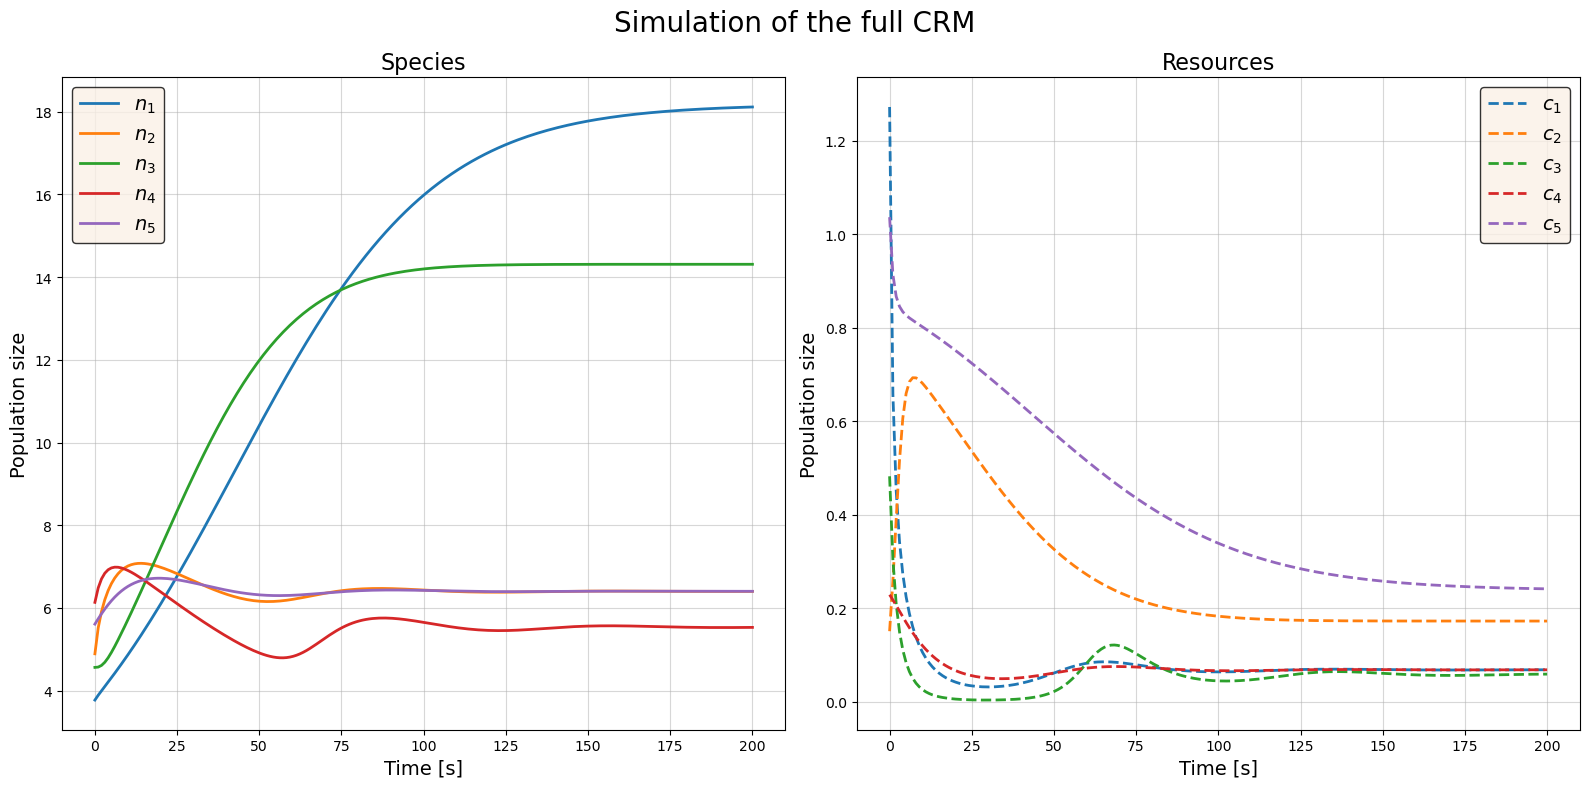

In [218]:
# simulation
np.random.seed(2222)
delta = [0.01]*m

# build alpha 
met_strat_trick = metabolic_strategies_trick(m, p)

# numerical solution
time_vec = np.linspace(0, 200, 200)
y_new = odeint(derivative, y0=m0+p0, t=time_vec, args=(met_strat_trick, delta, omega, kappa, m, p))

# plot the results
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Simulation of the full CRM', fontsize=20)

species = ax0.plot(time_vec, y_new[:, 0:m], linewidth=2)
ax0.set_xlabel('Time [s]', fontsize=14)
ax0.set_ylabel('Population size', fontsize=14)
ax0.grid(alpha=0.5)
ax0.legend(species, ['$n_'+str(i+1)+'$' for i in range(m)], edgecolor='black', facecolor='linen', fontsize=14 , loc ='best')
ax0.set_title('Species', fontsize=16)

resources = ax1.plot(time_vec, y_new[:, m:], linewidth=2, linestyle = 'dashed')
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel('Population size', fontsize=14)
ax1.grid(alpha=0.5)
ax1.legend(resources, ['$c_'+str(i+1)+'$' for i in range(m)], edgecolor='black', facecolor='linen', fontsize=14 , loc ='best')
ax1.set_title('Resources', fontsize=16)

plt.tight_layout()
plt.show()


In [219]:
resources_stat_num = y_new[-1, m:]
resources_stat_anal = resources_stationary_anal_0(met_strat_trick, delta)

species_stat_num = y_new[-1, 0:m]
species_stat_anal = species_stationary_anal_0(met_strat_trick, omega, kappa, c_anal=resources_stat_anal)

data = np.vstack((species_stat_num, species_stat_anal, resources_stat_num, resources_stat_anal)).T
mux = pd.MultiIndex.from_product([['Species','Resources'], ['Numerical','Analytical']])
df_ = pd.DataFrame(data, columns=mux, index=list(range(5)))


print('Stationary solution:')
df_ = df_.round(3)
df_[df_==0] = np.abs(df_[df_==0])
display(df_)


Stationary solution:


Species            Resources           
  Numerical Analytical Numerical Analytical
0    18.111     18.174     0.069      0.069
1     6.402      6.403     0.173      0.173
2    14.308     14.308     0.060      0.059
3     5.531      5.539     0.069      0.069
4     6.403      6.404     0.242      0.239

# Point 2

## Quasi stationary approximation
In the QSA we are assuming that the rate at which the resources change is much smaller than the rate at which the species abundances vary. In other words, when the species population change, the resources reach a new equilibrium quickly, anticipating a new change in the species population. 

The population dynamics follows the same equation as before:
$$
    \dot{n}_\sigma = n_\sigma\left(\sum_{i=1}^p \alpha_{\sigma i} c^*_i-\delta_\sigma \right) \quad \sigma=1, ..., m
$$

The resource concentrations are obtained by setting $\dot{c}_i=0 \; \forall i=1, ..., p$:
$$
\begin{align}
    0 &= \omega c_i^*(1-c_i^*/K) - \sum_{\sigma=1}^m n_\sigma \alpha_{\sigma i} (c_i^*) \quad  
    \Rightarrow \quad c_i^*= K\left[1-\frac{1}{\omega}\sum_{\sigma=1}^m n_\sigma \alpha_{\sigma i}\right] \quad i=1, ..., p
\end{align} 
$$

This can be substituted into the population dynamics to obtain $m$ equations in $m$ variables $n_\sigma$:
$$
    \dot{n}_\sigma = n_\sigma \left(K\sum_{i=1}^p \alpha_{\sigma i} \left[1-\frac{1}{\omega}\sum_{\sigma=1}^m n_\sigma \alpha_{\sigma i}\right] -\delta_\sigma \right) \quad \sigma=1, ..., m
$$ 



Write here how it works..., describe the fact that you use the trick...

In [223]:
# stationary solution, analytical
def analytical_stationary_solution(alpha, dr, omega_, k_):
    c_star = np.linalg.inv(alpha).dot(dr)
    n_star = omega_*np.linalg.inv(alpha.T).dot(1-c_star/k_)
    
    return c_star, n_star

# QSA dynamics
def derivative_QSA(y, time, alpha, dr, omega_):
    '''
    y = (n_vec) -> as a list
    
    time  -> time instant
    alpha -> metabolic strategies
    dr    -> death rate vector
    
    '''
        
    n_vec = np.array(y)
    c_star = 1-alpha.T.dot(n_vec)/omega_
    n_dot = n_vec*(np.dot(alpha, c_star)-dr)
        
    return n_dot.tolist()

In [246]:
np.random.seed(2222)

n_realizations = 50
omega = 10
time_vec = np.linspace(0, 200, 200)

# initialization
n_stat_QSA = []
n_stat_full = []

for i in range(n_realizations):
    met_strat_i = metabolic_strategies_trick(m, p)

    # simulation of the QSA
    y_QSA = odeint(derivative_QSA, y0=m0, t=time_vec, args=(met_strat_i, delta, omega))
    
    if i==0: 
        n_QSA_iter_0 = y_QSA
        c_QSA_iter_0 = (1-met_strat_i.T.dot(y_QSA.T)/omega).T
    n_stat_QSA.append(y_QSA[-1])
    
    # simulation of the full CRM
    y_full = odeint(derivative, y0=m0+p0, t=time_vec, args=(met_strat_i, delta, omega, kappa, m, p))
    if i==0: y_full_iter_0 = y_full
    n_stat_full.append(y_full[-1, :m])
    
# create list of stationary states for each pop in the 2 cases
pop_i_stat_QSA = []
pop_i_stat_full = []

for i in range(m):
    pop_i_stat_QSA.append([x[i] for x in n_stat_QSA])
    pop_i_stat_full.append([x[i] for x in n_stat_full])
    

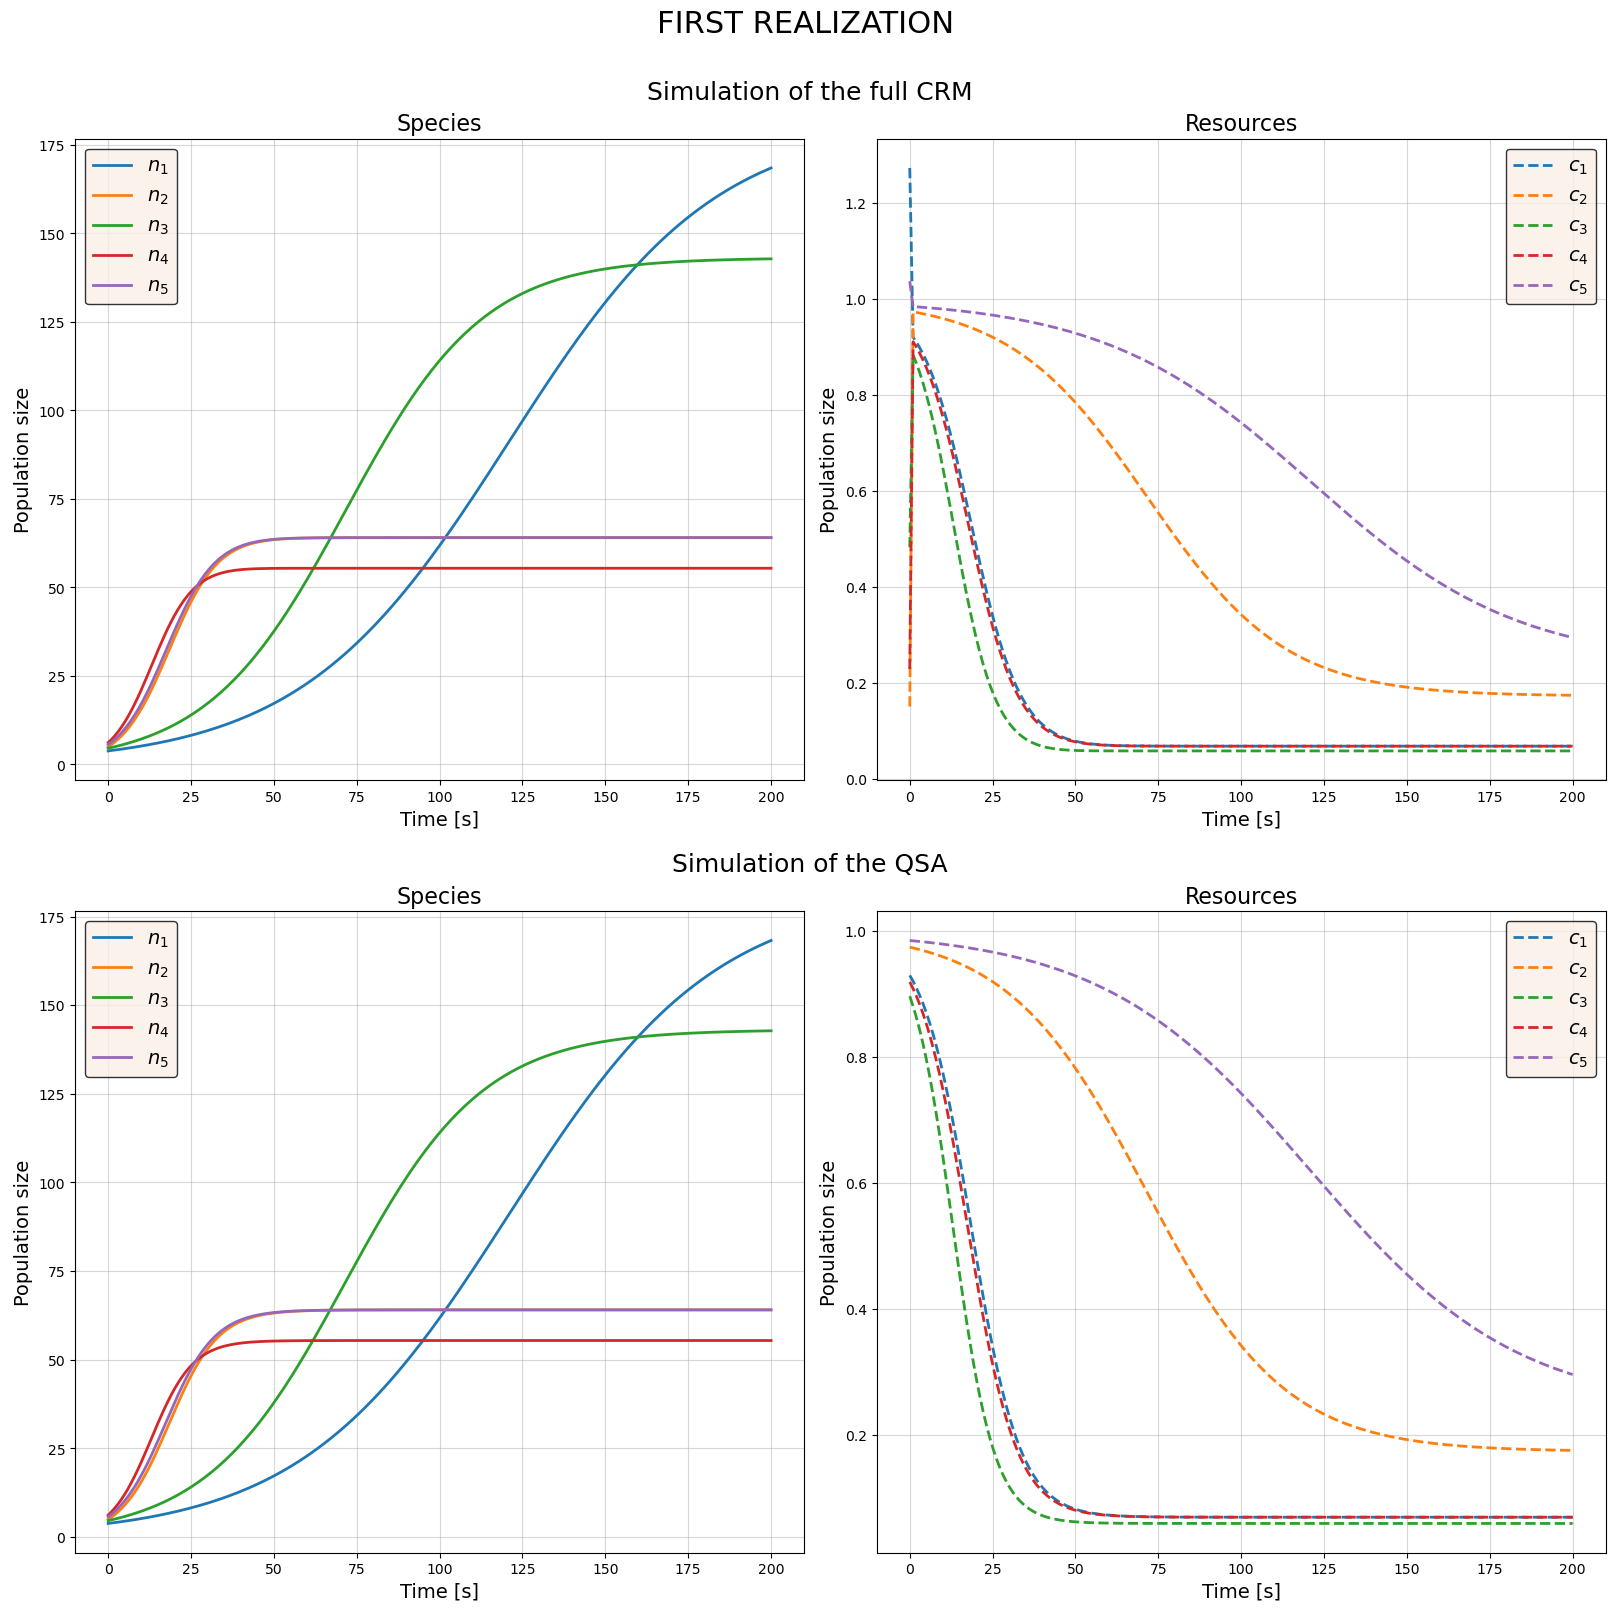

In [247]:
# plot the first iteration

# plot the results
fig = plt.figure(constrained_layout=True, figsize=(16, 16))
fig.suptitle('FIRST REALIZATION \n ', fontsize=22)
(subfig1, subfig2) = fig.subfigures(2, 1) # create 2x1 subfigures
(ax0, ax1) = subfig1.subplots(1, 2)       # create 1x2 subplots on subfig1
(ax2, ax3) = subfig2.subplots(1, 2)       # create 1x2 subplots on subfig2

subfig1.suptitle('Simulation of the full CRM', fontsize=18)
species = ax0.plot(time_vec, y_full_iter_0[:, :m], linewidth=2)
ax0.set_xlabel('Time [s]', fontsize=14)
ax0.set_ylabel('Population size', fontsize=14)
ax0.grid(alpha=0.5)
ax0.legend(species, ['$n_'+str(i+1)+'$' for i in range(m)], edgecolor='black', facecolor='linen', fontsize=14 , loc ='upper left')
ax0.set_title('Species', fontsize=16)

resources = ax1.plot(time_vec, y_full_iter_0[:, m:], linewidth=2, linestyle = 'dashed')
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel('Population size', fontsize=14)
ax1.grid(alpha=0.5)
ax1.legend(resources, ['$c_'+str(i+1)+'$' for i in range(m)], edgecolor='black', facecolor='linen', fontsize=14 , loc ='upper right')
ax1.set_title('Resources', fontsize=16)

subfig2.suptitle('Simulation of the QSA', fontsize=18)
species = ax2.plot(time_vec, n_QSA_iter_0, linewidth=2)
ax2.set_xlabel('Time [s]', fontsize=14)
ax2.set_ylabel('Population size', fontsize=14)
ax2.grid(alpha=0.5)
ax2.legend(species, ['$n_'+str(i+1)+'$' for i in range(m)], edgecolor='black', facecolor='linen', fontsize=14 , loc ='upper left')
ax2.set_title('Species', fontsize=16)

resources = ax3.plot(time_vec, c_QSA_iter_0, linewidth=2, linestyle = 'dashed')
ax3.set_xlabel('Time [s]', fontsize=14)
ax3.set_ylabel('Population size', fontsize=14)
ax3.grid(alpha=0.5)
ax3.legend(resources, ['$c_'+str(i+1)+'$' for i in range(m)], edgecolor='black', facecolor='linen', fontsize=14 , loc ='upper right')
ax3.set_title('Resources', fontsize=16)

plt.show()

In [241]:
# boxplot function
def boxplot(ax, y, colors, linewidth=2, color_median='black', linewidth_median = 3, size_props = 12, title = 'boxplot', font_title = 16, xlabel='x_axis', x_font=14, ylabel='y_axis', y_font=14, labels=False, list_labels=[] ):
    '''
    The boxplot function takes only one mandatory argument: y that is either a matrix-like with the series to plot as columns or an array-like of array-likes.
    
    Then it accepts the following key-word arguments:
    1) y: a list of the sequences to plot
    2) colors: a list with the colors of the boxes,
    
    3) title, xlabel and ylabel: self explanatory, we have also as far as the fontsize font_title, x_font, y_font.
    4) color_median: the color of the median
    5) linewidth_median: self explanatory
    6) size_props: size of the outliers
    
    '''
    
    bp = ax.boxplot(y,boxprops=dict(linewidth=linewidth), patch_artist=True, medianprops=dict(color=color_median, linewidth=linewidth_median), flierprops=dict(markersize=size_props))
    
    ax.set_title(title, fontsize=font_title)
    ax.set_xlabel(xlabel, fontsize=x_font)
    ax.set_ylabel(ylabel, fontsize=y_font)

    #Still to insert the case were y is a matrix
    
    for array, x_point, color in zip(y, range(1, len(y)+1), colors) :
        tmp = np.ones([len(array),])*x_point + 0.35
        ax.scatter(tmp, array, s=77, alpha=0.5, edgecolor='black', color=color)

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
   
    ax.minorticks_on()
    ax.xaxis.set_tick_params(which='minor', bottom=False , size=8)
    ax.yaxis.set_tick_params(labelsize=10, size=8)

    if labels:
        ax.set_xticklabels(list_labels)
           
    return ax, bp


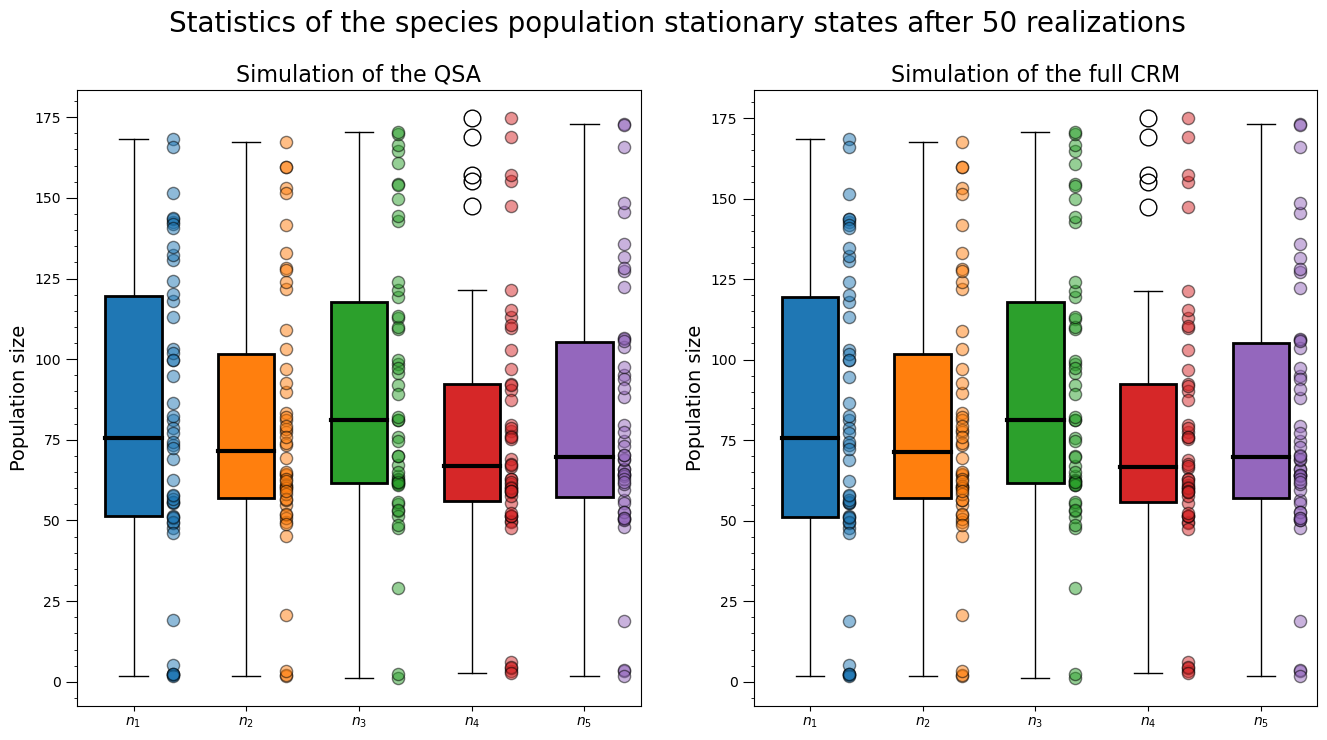

In [248]:
# Box-Whisker Plot
fig, ax = plt.subplots(1,2,figsize=(16, 8))

boxplot(ax[0], y=pop_i_stat_QSA , colors=['C0', 'C1', 'C2', 'C3', 'C4'],  title = 'Simulation of the QSA', ylabel= 'Population size', xlabel='', labels=True, list_labels=['$n_1$', '$n_2$', '$n_3$', '$n_4$', '$n_5$'] )
boxplot(ax[1], y=pop_i_stat_full, colors=['C0', 'C1', 'C2', 'C3', 'C4'],  title = 'Simulation of the full CRM', ylabel= 'Population size', xlabel='', labels=True, list_labels=['$n_1$', '$n_2$', '$n_3$', '$n_4$', '$n_5$'] )

fig.suptitle('Statistics of the species population stationary states after %i realizations' %n_realizations, fontsize=20)
plt.show()


## Comments
Comment the boxplot here....

# Point 3

## Comments